In [75]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
from keras import backend as K

In [2]:
# Load data
data = np.load("data.npz")
X = data["arr_0"]
Y = data["arr_1"]
print("# Normal Images:", len(Y[np.where(Y == 0)]))
print("# Pothole Images:", len(Y[np.where(Y == 1)]))
print("# Total Images:", len(Y))

# Normal Images: 365
# Pothole Images: 1301
# Total Images: 1666


In [32]:
# Perform train-test split
# https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
# https://stackoverflow.com/questions/3674409/how-to-split-partition-a-dataset-into-training-and-test-datasets-for-e-g-cros
def shuffle(a, b):
  assert len(a) == len(b)
  p = np.random.permutation(len(a))
  return a[p], b[p]

def train_test_split(X, Y, test_prop):
  X, Y = shuffle(X, Y)
  split_index = int(test_prop * len(X))
  X_train = X[split_index:]
  Y_train = Y[split_index:]
  X_test = X[:split_index]
  Y_test = Y[:split_index]
  return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = train_test_split(X, Y, 0.3)
print("Total data:", X.shape)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Total data: (1666, 64, 64, 3)
Train shape: (1167, 64, 64, 3)
Test shape: (499, 64, 64, 3)


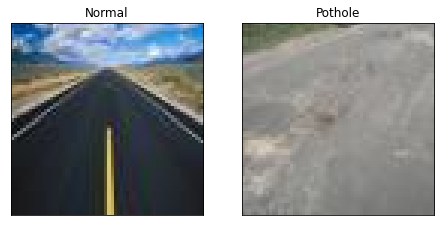

In [33]:
# Display sample images
class_names = ["Normal", "Pothole"]
fig = plt.figure(figsize=(20,10))
for i in range(len(class_names)):
  ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
  idx = np.where(Y_train[:]==i)[0]
  features_idx = X_train[idx,::]
  img_num = np.random.randint(features_idx.shape[0])
  im = features_idx[img_num,::]
  ax.set_title(class_names[i])
  plt.imshow(im)
plt.show()

In [34]:
# Loss functions
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [38]:
# Set hyperparameters
# Probably don't change these
input_width = 64
input_height = 64
input_depth = 3

num_epochs = 100
batch_size = 128
learning_rate = 0.0005
dropout_rate = 0.25 # This is multiplied by 2 at some point so should be <0.5 or change the usage

In [39]:
# Max Norm Constraints w/Dropout

# Initializing the model
model = Sequential()
# Defining a convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(input_width, input_height, input_depth)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_rate))
# We add our classificator
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_constraint=max_norm(3.)))
model.add(Dropout(dropout_rate * 2))
model.add(Dense(2, activation='softmax'))
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=learning_rate, decay=1e-6),
              metrics=['accuracy', f1_m, precision_m, recall_m])
# Training of the model
model.fit(X_train, to_categorical(Y_train),
          batch_size=batch_size,
          shuffle=True,
          epochs=num_epochs,
          verbose=2,
          validation_data=(X_test, to_categorical(Y_test)))
# Evaluation of the model
scores = model.evaluate(X_test, to_categorical(Y_test))
print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

Epoch 1/100


2022-04-30 13:50:06.322732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-30 13:50:07.632881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 - 3s - loss: 141.2120 - accuracy: 0.6247 - f1_m: 0.6284 - precision_m: 0.6284 - recall_m: 0.6284 - val_loss: 62.7565 - val_accuracy: 0.7996 - val_f1_m: 0.7981 - val_precision_m: 0.7981 - val_recall_m: 0.7981 - 3s/epoch - 338ms/step
Epoch 2/100
10/10 - 1s - loss: 32.7784 - accuracy: 0.6727 - f1_m: 0.6662 - precision_m: 0.6662 - recall_m: 0.6662 - val_loss: 1.9955 - val_accuracy: 0.8838 - val_f1_m: 0.8841 - val_precision_m: 0.8841 - val_recall_m: 0.8841 - 866ms/epoch - 87ms/step
Epoch 3/100
10/10 - 1s - loss: 4.6501 - accuracy: 0.8072 - f1_m: 0.7889 - precision_m: 0.7889 - recall_m: 0.7889 - val_loss: 0.8227 - val_accuracy: 0.8918 - val_f1_m: 0.8921 - val_precision_m: 0.8921 - val_recall_m: 0.8921 - 825ms/epoch - 83ms/step
Epoch 4/100
10/10 - 1s - loss: 0.8441 - accuracy: 0.8132 - f1_m: 0.8179 - precision_m: 0.8179 - recall_m: 0.8179 - val_loss: 0.2932 - val_accuracy: 0.8858 - val_f1_m: 0.8862 - val_precision_m: 0.8862 - val_recall_m: 0.8862 - 874ms/epoch - 87ms/step
Epoch 5/100
10

Epoch 34/100
10/10 - 1s - loss: 0.1025 - accuracy: 0.9306 - f1_m: 0.9367 - precision_m: 0.9367 - recall_m: 0.9367 - val_loss: 0.2029 - val_accuracy: 0.9399 - val_f1_m: 0.9401 - val_precision_m: 0.9401 - val_recall_m: 0.9401 - 866ms/epoch - 87ms/step
Epoch 35/100
10/10 - 1s - loss: 0.1039 - accuracy: 0.9254 - f1_m: 0.9261 - precision_m: 0.9261 - recall_m: 0.9261 - val_loss: 0.2130 - val_accuracy: 0.9379 - val_f1_m: 0.9381 - val_precision_m: 0.9381 - val_recall_m: 0.9381 - 862ms/epoch - 86ms/step
Epoch 36/100
10/10 - 1s - loss: 0.1000 - accuracy: 0.9280 - f1_m: 0.9344 - precision_m: 0.9344 - recall_m: 0.9344 - val_loss: 0.2200 - val_accuracy: 0.9379 - val_f1_m: 0.9381 - val_precision_m: 0.9381 - val_recall_m: 0.9381 - 872ms/epoch - 87ms/step
Epoch 37/100
10/10 - 1s - loss: 0.0949 - accuracy: 0.9340 - f1_m: 0.9340 - precision_m: 0.9340 - recall_m: 0.9340 - val_loss: 0.2151 - val_accuracy: 0.9379 - val_f1_m: 0.9381 - val_precision_m: 0.9381 - val_recall_m: 0.9381 - 863ms/epoch - 86ms/step


Epoch 67/100
10/10 - 1s - loss: 0.0610 - accuracy: 0.9666 - f1_m: 0.9695 - precision_m: 0.9695 - recall_m: 0.9695 - val_loss: 0.2561 - val_accuracy: 0.9259 - val_f1_m: 0.9264 - val_precision_m: 0.9264 - val_recall_m: 0.9264 - 872ms/epoch - 87ms/step
Epoch 68/100
10/10 - 1s - loss: 0.0713 - accuracy: 0.9623 - f1_m: 0.9656 - precision_m: 0.9656 - recall_m: 0.9656 - val_loss: 0.3586 - val_accuracy: 0.9399 - val_f1_m: 0.9401 - val_precision_m: 0.9401 - val_recall_m: 0.9401 - 782ms/epoch - 78ms/step
Epoch 69/100
10/10 - 1s - loss: 0.0690 - accuracy: 0.9734 - f1_m: 0.9758 - precision_m: 0.9758 - recall_m: 0.9758 - val_loss: 0.2623 - val_accuracy: 0.9178 - val_f1_m: 0.9184 - val_precision_m: 0.9184 - val_recall_m: 0.9184 - 805ms/epoch - 80ms/step
Epoch 70/100
10/10 - 1s - loss: 0.0594 - accuracy: 0.9743 - f1_m: 0.9766 - precision_m: 0.9766 - recall_m: 0.9766 - val_loss: 0.2832 - val_accuracy: 0.9279 - val_f1_m: 0.9281 - val_precision_m: 0.9281 - val_recall_m: 0.9281 - 730ms/epoch - 73ms/step


Epoch 100/100
10/10 - 1s - loss: 0.0577 - accuracy: 0.9777 - f1_m: 0.9797 - precision_m: 0.9797 - recall_m: 0.9797 - val_loss: 0.3036 - val_accuracy: 0.9339 - val_f1_m: 0.9342 - val_precision_m: 0.9342 - val_recall_m: 0.9342 - 741ms/epoch - 74ms/step
16/16 [==============================] - 0s 27ms/step - loss: 0.3036 - accuracy: 0.9339 - f1_m: 0.9329 - precision_m: 0.9329 - recall_m: 0.9329
Loss: 0.304
Accuracy: 0.934


In [77]:
Y_pred = model.predict(X_test)

# https://stackoverflow.com/questions/46953967/multilabel-indicator-is-not-supported-for-confusion-matrix
matrix = confusion_matrix(Y_test, Y_pred.argmax(axis=1))
matrix

array([[ 82,  18],
       [ 15, 384]])

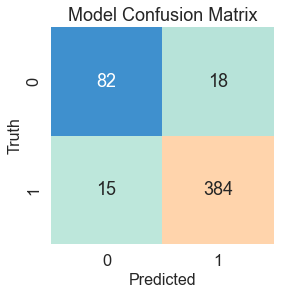

In [116]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
#https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
#https://www.tutorialspoint.com/how-to-hide-the-colorbar-of-a-seaborn-heatmap
#https://www.delftstack.com/howto/seaborn/set-axis-labels-seaborn-python/
#http://seaborn.pydata.org/tutorial/color_palettes.html

df_cm = pd.DataFrame(matrix, range(2), range(2))
plt.figure(figsize=(4,4))
sn.set(font_scale=1.5) # label size
p = sn.heatmap(df_cm, fmt='.3g', annot=True, annot_kws={"size": 18}, cbar=False, cmap="icefire")
p.set_xlabel("Predicted", fontsize = 16)
p.set_ylabel("Truth", fontsize = 16)
plt.title('Model Confusion Matrix')
plt.show()